# ChArUco

- ref: https://github.com/kyle-bersani/opencv-examples
- don't use digital smoothing!

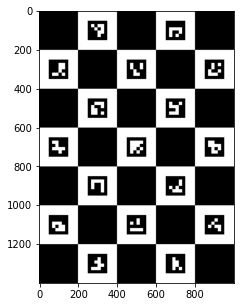

True

In [1]:
import cv2
import cv2.aruco as aruco
import imageio
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
from tqdm import tqdm
import pickle

aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_1000)
charuco = aruco.CharucoBoard_create(
        squaresX=5,
        squaresY=7,
        squareLength=0.04,
        markerLength=0.02,
        dictionary=aruco_dict)

img = charuco.draw(outSize=(1000, 1400))
plt.figure(figsize=(5,5)); plt.imshow(img, cmap="gray"); plt.show()
cv2.imwrite("src/charuco.jpg", img)

In [2]:
# save to pdf (A4)
import img2pdf  # pip install img2pdf
a4inpt = (img2pdf.mm_to_pt(210),img2pdf.mm_to_pt(297))
layout_fun = img2pdf.get_layout_fun(a4inpt)
with open("src/charuco.pdf","wb") as f:
	f.write(img2pdf.convert('src/charuco.jpg', layout_fun=layout_fun))

(269, 1080, 1920, 3)


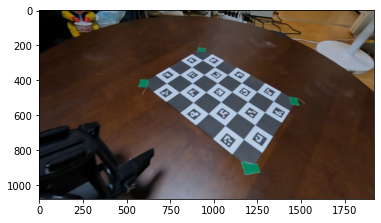

In [2]:
vid = np.array(imageio.mimread("src/charuco.mp4", memtest=False))
print(vid.shape)
plt.imshow(vid[0]); plt.show()

In [3]:
def calib(vid):
    corners_all = []
    ids_all = []

    for t, img in enumerate(vid):
        img = deepcopy(img)
        gray = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_RGB2BGR),cv2.COLOR_BGR2GRAY)
        corners, ids, _ = aruco.detectMarkers(
                image=gray,
                dictionary=aruco_dict)

        img = aruco.drawDetectedMarkers(
                image=img, 
                corners=corners)

        response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
                markerCorners=corners,
                markerIds=ids,
                image=gray,
                board=charuco)

        if response < 10:
            print("Not able to detect a charuco board in image: t={}".format(t))
            continue

        corners_all.append(charuco_corners)
        ids_all.append(charuco_ids)

        img = aruco.drawDetectedCornersCharuco(
                image=img,
                charucoCorners=charuco_corners,
                charucoIds=charuco_ids)

        if t < 1:
            plt.figure(figsize=(10,10)); plt.imshow(img); plt.show()

    print("Number of detected frames:", len(corners_all))
    ret, cameraMatrix, distCoeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(
            charucoCorners=corners_all,
            charucoIds=ids_all,
            board=charuco,
            imageSize=vid.shape[2:0:-1],
            cameraMatrix=None,
            distCoeffs=None)

    print('ret\n', ret, '\nmtx\n', cameraMatrix, '\ndist\n', distCoeffs)
    return cameraMatrix, distCoeffs

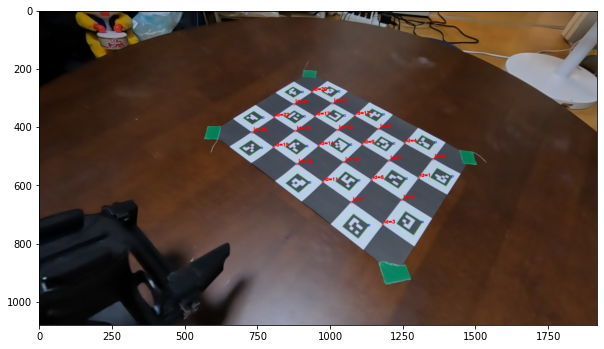

Number of detected frames: 44
ret
 0.1907718013134449 
mtx
 [[921.17693735   0.         949.59526529]
 [  0.         922.21120502 549.32688628]
 [  0.           0.           1.        ]] 
dist
 [[ 0.02125802 -0.09120418  0.00306985 -0.00375586  0.14344269]]


In [4]:
mtx, dist = calib(vid[25:-25:5])
with open('camera.pkl', 'wb') as f:
    pickle.dump((mtx, dist), f)

  0%|                                                     | 0/269 [00:00<?, ?it/s]

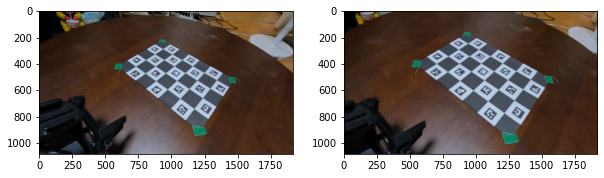

100%|███████████████████████████████████████████| 269/269 [00:09<00:00, 29.89it/s]


In [5]:
vid_undist = []

newmtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (vid.shape[2], vid.shape[1]), 0)

for t, img in enumerate(tqdm(vid)):
    img = deepcopy(img)
    dst = cv2.undistort(img, mtx, dist, None, newmtx)
    vid_undist.append(dst)

    if t==0:
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1); plt.imshow(img)
        plt.subplot(1,2,2); plt.imshow(dst); 
        plt.show()

imageio.mimwrite("src/charuco_undist.mp4", vid_undist, macro_block_size=8)
vid_undist = np.array(imageio.mimread("src/charuco_undist.mp4", memtest=False))

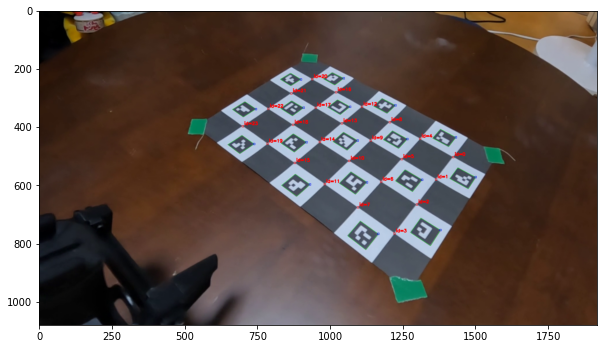

Number of detected frames: 44
ret
 0.2498260627927993 
mtx
 [[1.07928452e+03 0.00000000e+00 9.51528545e+02]
 [0.00000000e+00 1.08147025e+03 5.39888885e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
dist
 [[-2.45852670e-03  1.54580014e-02  4.33689533e-05  8.64405425e-05
  -2.09113249e-02]]


In [6]:
mtx, dist = calib(vid_undist[25:-25:5])
with open('camera.pkl', 'wb') as f:
    pickle.dump((mtx, dist), f)

---

In [7]:
import cv2
import cv2.aruco as aruco
import numpy as np
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy
from tqdm import tqdm
import pickle


vid = np.array(imageio.mimread("src/charuco_undist.mp4", memtest=False))
print(vid.shape)

with open('camera.pkl', 'rb') as f:
    (cameraMatrix, distCoeffs) = pickle.load(f)

aruco_params = aruco.DetectorParameters_create()
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_1000)
charuco = aruco.CharucoBoard_create(
        squaresX=5,
        squaresY=7,
        squareLength=0.04,
        markerLength=0.02,
        dictionary=aruco_dict)

(269, 1080, 1920, 3)


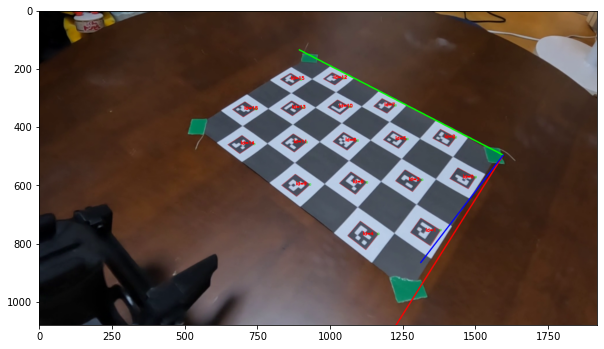

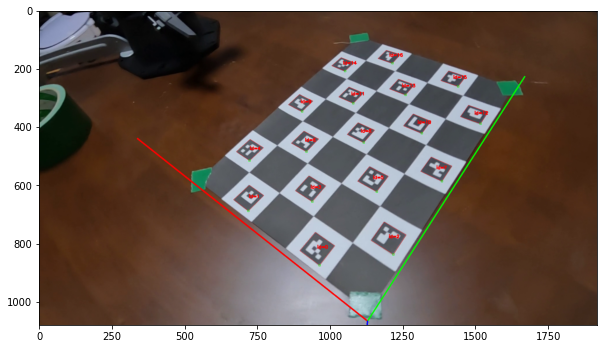

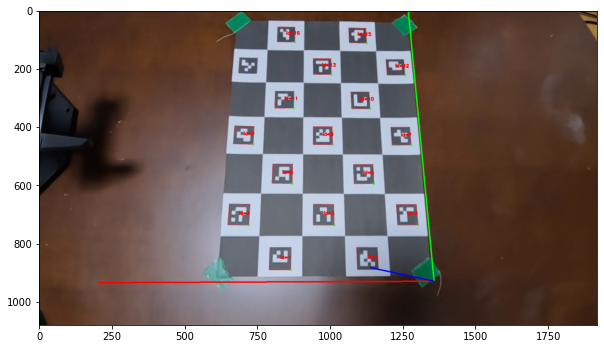

In [8]:
for i, frame in enumerate(vid[25:-25:100]):
    frame = deepcopy(frame[...,::-1])
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = charuco,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = cameraMatrix,
            distCoeffs = distCoeffs)

    frame = aruco.drawDetectedMarkers(frame, corners, borderColor=(0, 0, 255), ids=ids)

    if not (ids is not None and len(ids) > 1):
        continue

    response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=gray,
            board=charuco)

    if not (response is not None and response > 2):
        continue

    pose, rvec, tvec = aruco.estimatePoseCharucoBoard(
            charucoCorners=charuco_corners,
            charucoIds=charuco_ids,
            board=charuco, 
            cameraMatrix=cameraMatrix,
            distCoeffs=distCoeffs,
            rvec=None,
            tvec=None)

    frame = cv2.drawFrameAxes(frame, cameraMatrix, distCoeffs, rvec, tvec, 0.3)

    plt.figure(figsize=(10,10)); plt.imshow(frame[...,::-1]); plt.show()

  0%|                                                     | 0/269 [00:00<?, ?it/s]

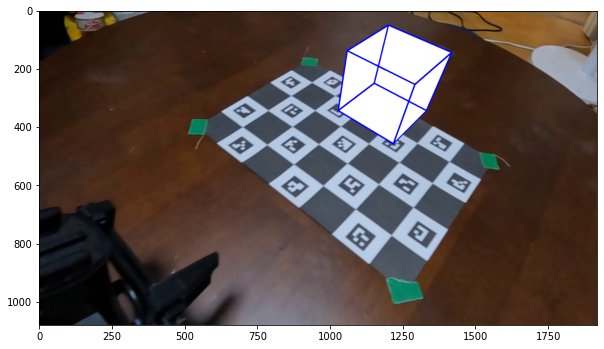

100%|███████████████████████████████████████████| 269/269 [00:03<00:00, 70.98it/s]


In [9]:
cube = np.float32([[0,0,0], [0,1,0], [1,1,0], [1,0,0],
                   [0,0,-1],[0,1,-1],[1,1,-1],[1,0,-1]])
cube =  (cube * 2 + np.array([[-0.5,2.5,0]])) * 0.04
# cube =  (cube * 1 + np.array([[2,3,0]])) * 0.04

def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)
    img = cv2.drawContours(img, [imgpts[[0,1,2,3]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[0,1,5,4]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[0,3,7,4]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[1,2,6,5]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[2,3,7,6]]], -1, (255,255,255), -1)
    img = cv2.drawContours(img, [imgpts[[4,5,6,7]]], -1, (255,255,255), -1)
    for i, j in zip(range(0, 4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (0,0,255), 3)
    img = cv2.drawContours(img, [imgpts[0:4]], -1, (0,0,255), 3)
    img = cv2.drawContours(img, [imgpts[4:8]], -1, (0,0,255), 3)
    return img



vid_paint = []

for t, frame in enumerate(tqdm(vid)):
    frame = deepcopy(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = charuco,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = cameraMatrix,
            distCoeffs = distCoeffs)

    # don't draw! for saving vid
    # frame = aruco.drawDetectedMarkers(frame, corners, borderColor=(0, 0, 255), ids=ids)

    if not (ids is not None and len(ids) > 1):
        continue

    response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=gray,
            board=charuco)

    if not (response is not None and response > 2):
        continue

    pose, rvec, tvec = aruco.estimatePoseCharucoBoard(
            charucoCorners=charuco_corners,
            charucoIds=charuco_ids,
            board=charuco, 
            cameraMatrix=cameraMatrix,
            distCoeffs=distCoeffs,
            rvec=None,
            tvec=None)
    
    
    imgpts, jac = cv2.projectPoints(cube, rvec, tvec, cameraMatrix, distCoeffs)
    frame = draw(frame, imgpts)
    vid_paint.append(frame)

    if t==0:
        plt.figure(figsize=(10,10))
        plt.imshow(frame)
        plt.show()

# imageio.mimwrite("src/charuco_paint.mp4", vid_paint, macro_block_size=8)
# vid_paint = np.array(imageio.mimread("src/charuco_paint.mp4", memtest=False))

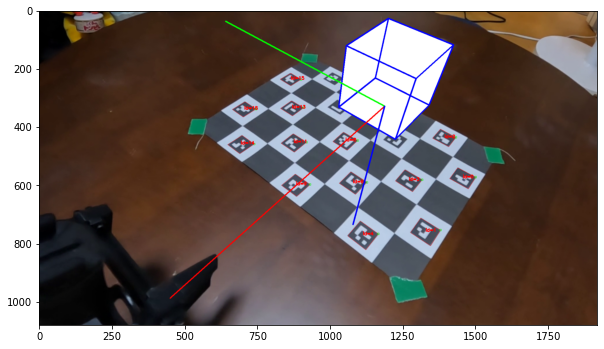

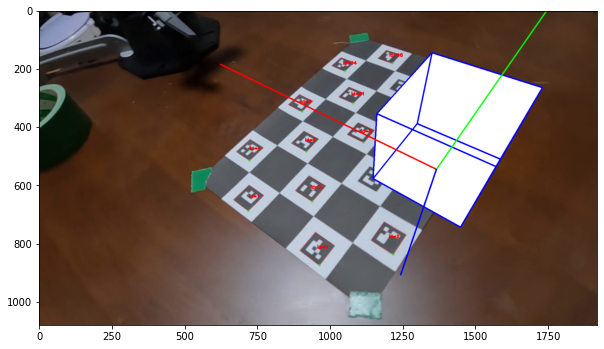

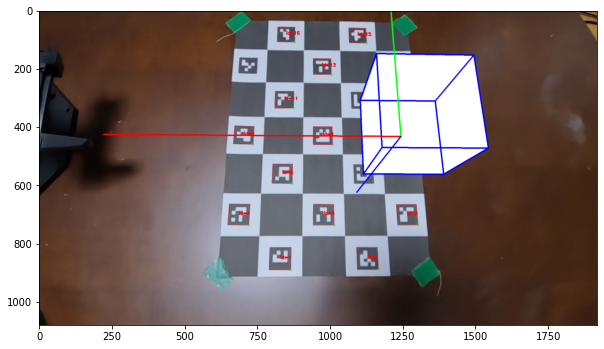

In [10]:
for i, frame in enumerate(vid_paint[25:-25:100]):
    frame = deepcopy(frame[...,::-1])
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = charuco,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = cameraMatrix,
            distCoeffs = distCoeffs)

    frame = aruco.drawDetectedMarkers(frame, corners, borderColor=(0, 0, 255), ids=ids)

    if not (ids is not None and len(ids) > 1):
        continue

    response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=gray,
            board=charuco)

    if not (response is not None and response > 2):
        continue

    # valid, rvec, tvec = aruco.estimatePoseCharucoBoard(
    #         charucoCorners=charuco_corners,
    #         charucoIds=charuco_ids,
    #         board=charuco, 
    #         cameraMatrix=cameraMatrix,
    #         distCoeffs=distCoeffs,
    #         rvec=None,
    #         tvec=None)
    
    # Customized aruco.estimatePoseCharucoBoard
    objp = np.empty((0,3), np.float32)
    for idx in charuco_ids:
        objp = np.append(objp, charuco.chessboardCorners[idx] - np.array([[0.5,3.5,0]]) * 0.04, axis=0)

    valid, rvec, tvec = cv2.solvePnP(objp, charuco_corners, cameraMatrix, distCoeffs)

    if valid:
        frame = cv2.drawFrameAxes(frame, cameraMatrix, distCoeffs, rvec, tvec, 0.3)
        plt.figure(figsize=(10,10)); plt.imshow(frame[...,::-1]); plt.show()
    else:
        print('pose estimation failed')